<a href="https://colab.research.google.com/github/lxxhxng/aipython/blob/main/%EC%A4%91%EA%B3%A0%EC%B0%A8%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
!pip install catboost;

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# train/test data 불러오기

df_train = pd.read_csv('/content/gdrive/MyDrive/IBA/IBA_reg_comp/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/IBA/IBA_reg_comp/test.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58627 entries, 0 to 58626
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         58627 non-null  object 
 1   model         58627 non-null  object 
 2   year          58627 non-null  int64  
 3   transmission  58627 non-null  object 
 4   mileage       57849 non-null  float64
 5   fuelType      58627 non-null  object 
 6   tax           53515 non-null  float64
 7   mpg           53035 non-null  float64
 8   engineSize    58627 non-null  float64
 9   price         58627 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 4.5+ MB


# 데이터 전처리

## 이상치 처리

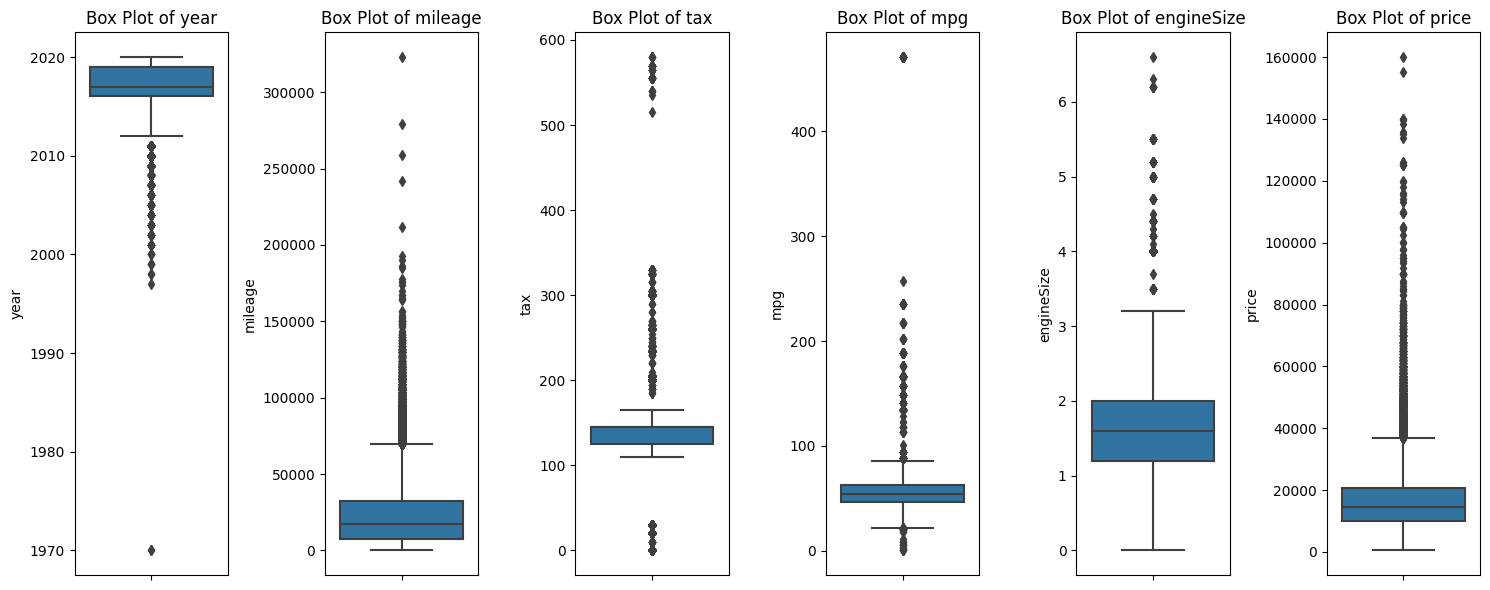

In [ ]:
# 연속형 변수에 대한 boxplot

features_to_visualize = ['year' ,'mileage', 'tax', 'mpg', 'engineSize', 'price']
plt.figure(figsize=(15, 6))

for i, feature in enumerate(features_to_visualize):
    plt.subplot(1, len(features_to_visualize), i+1)
    sns.boxplot(y=df_train[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

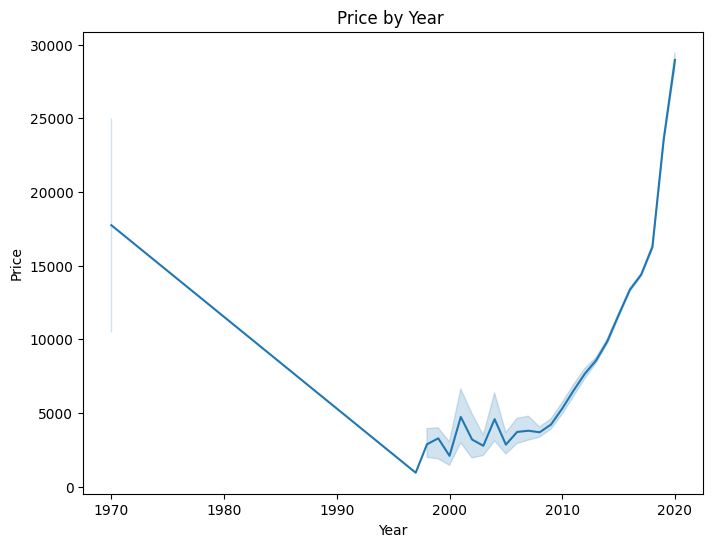

In [ ]:
# 이상치가 존재하는 Year 에대한 lineplot

plt.figure(figsize=(8,6))
sns.lineplot(x='year', y='price', data=df_train, palette='Pastel1')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price by Year ')
plt.show()

In [ ]:
# Year에서 너무 독단적으로 위치해있는 1970년도의 2개의 데이터 존재

df_train[df_train['year']==1970]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
18945,vauxhall,Zafira,1970,Manual,37357.0,Petrol,NaN,42.2,1.4,10495
54861,merc,M Class,1970,Automatic,14000.0,Diesel,305.0,39.2,0.0,24999


In [ ]:
# 데이터 제거후 확인

df_train = df_train[df_train['year'] != 1970]
df_train[df_train['year']==1970]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price


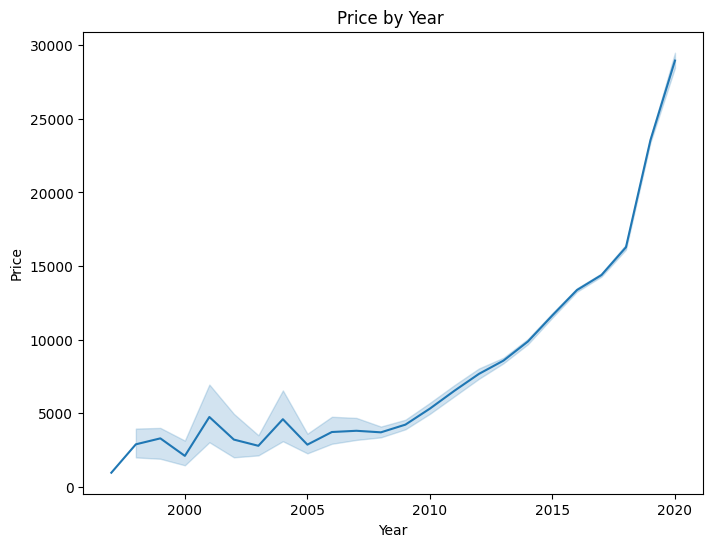

In [ ]:
# 제거 후 Lineplot

plt.figure(figsize=(8,6))
sns.lineplot(x='year', y='price', data=df_train, palette='Pastel1')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price by Year ')
plt.show()

# 1970년도의 데이터를 제거한후 Year와 Price간의 관계가 뚜렸해짐 -> 모델링 과정에서도 도움이 될것으로 보임

In [ ]:
df_train[df_train['mpg']>400]

# mpg에서 400 이상의 결측치는 확인결과 BMW사의 I3 모델들로 확인되고 구글링 결과 가능성있는 수치임
# 나머지 feature에 대해서는 모두 의미가 있다고 판단하여 이상치를 제거하지 않음

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
1069,bmw,i3,2016,Automatic,20013.0,Hybrid,0.0,470.8,0.0,19875
2052,bmw,i3,2015,Automatic,79830.0,Hybrid,0.0,470.8,0.0,12500
2156,bmw,i3,2016,Automatic,43695.0,Hybrid,0.0,470.8,0.0,16482
4165,bmw,i3,2017,Automatic,24041.0,Hybrid,0.0,470.8,0.0,21495
4398,bmw,i3,2016,Automatic,25269.0,Other,0.0,470.8,0.6,17100
6061,bmw,i3,2017,Automatic,41949.0,Hybrid,140.0,470.8,0.0,19998
9173,bmw,i3,2017,Automatic,29851.0,Hybrid,0.0,470.8,0.0,19895
11393,bmw,i3,2015,Automatic,65800.0,Hybrid,0.0,470.8,0.0,14285
11409,bmw,i3,2017,Automatic,23956.0,Other,135.0,470.8,0.6,19500
11674,bmw,i3,2015,Automatic,59000.0,Other,NaN,470.8,0.6,14940


## 결측치 처리

In [ ]:
# 결측치 확인

df_train.isnull().sum()

# mileage, tax, mpg 열에 결측치가 존재

brand              0
model              0
year               0
transmission       0
mileage          778
fuelType           0
tax             5111
mpg             5592
engineSize         0
price              0
dtype: int64

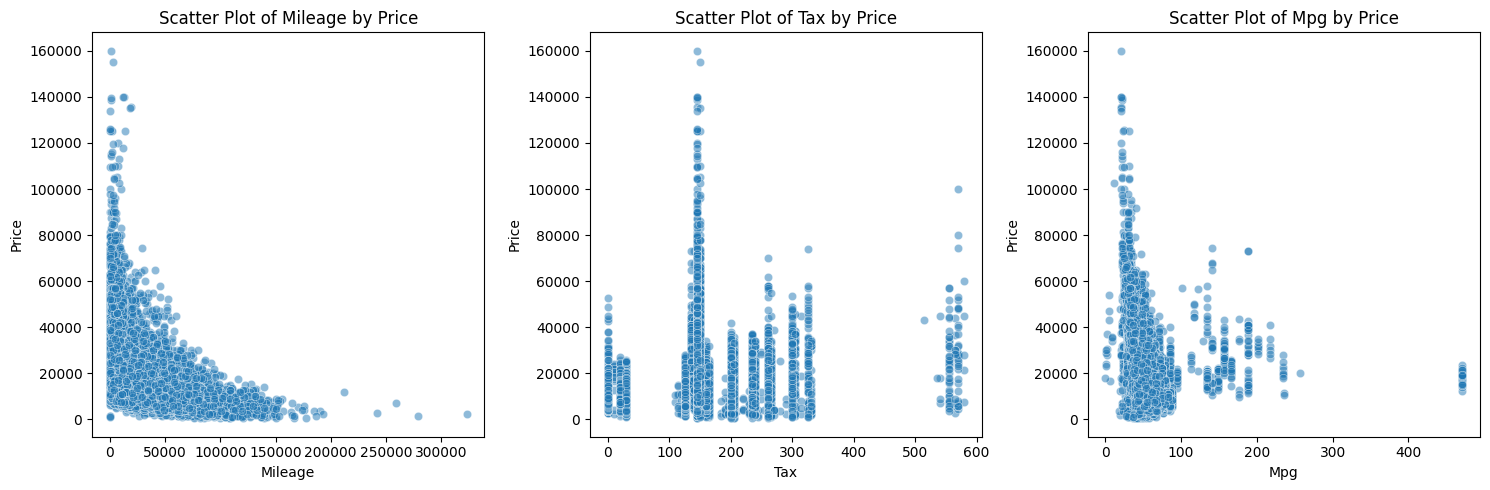

In [ ]:
# 결측치가 존재하는 feature에 대해 price와의 관계성을 시각화 하고자 scatterplot 시각화

missing_features = ['mileage', 'tax', 'mpg']

plt.figure(figsize=(15, 5))

for i, var in enumerate(missing_features):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(data=df_train, x=var, y='price', alpha=0.5)
    plt.title(f'Scatter Plot of {var.capitalize()} by Price')
    plt.xlabel(var.capitalize())
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

### Mileage

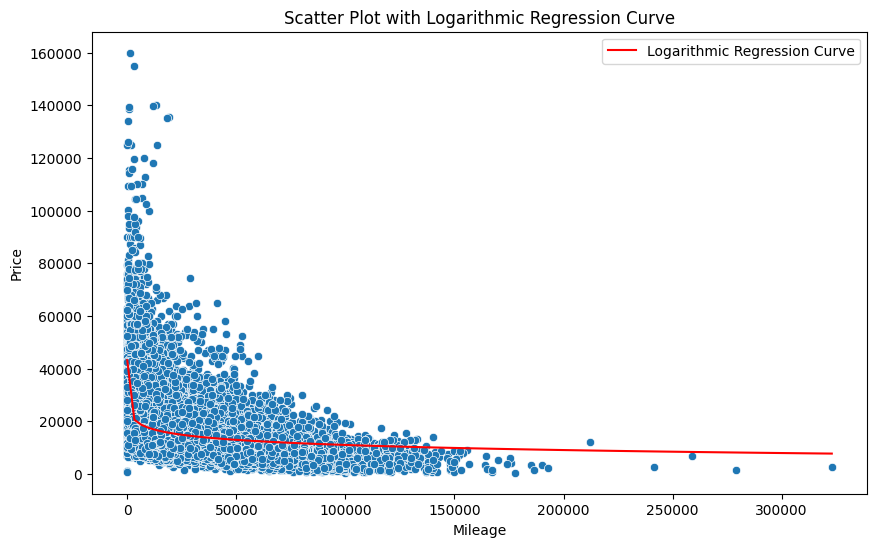

In [ ]:
# Mileage와 Price의 산점도 그래프에 의미가 있어보여서 log함수로 회귀 시도

# log함수 회귀 곡선을 그리기 위해 df_mile_dropped 에 mileage결측치 제거한 데이터 생성
df_mile_dropped = df_train.copy()

# 결측치가 있는 행 제거
df_mile_dropped.dropna(subset=['mileage'], inplace=True)

# 산점도 그래프 그리기
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mile_dropped, x='mileage', y='price')

# 로그 함수 모델 정의
def logarithmic_func(x, a, b):
    return a * np.log(x) + b

# 모델 학습
x_data = df_mile_dropped['mileage'].values
y_data = df_mile_dropped['price'].values
params, _ = curve_fit(logarithmic_func, x_data, y_data)

# 회귀 곡선을 그리기 위한 데이터 포인트 생성
x_curve = np.linspace(min(x_data), max(x_data), 100)
y_curve = logarithmic_func(x_curve, *params)

# 회귀 곡선 그리기
plt.plot(x_curve, y_curve, color='red', label='Logarithmic Regression Curve')
plt.title('Scatter Plot with Logarithmic Regression Curve')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# # 결측치 대치 함수
# def fill_missing_mileage(row):
#     if pd.isnull(row['mileage']):
#         pred_mileage = logarithmic_func(row['price'], *params)
#         return pred_mileage
#     else:
#         return row['mileage']

# # 모델 학습
# x_data = df_train.dropna(subset=['mileage'])['mileage'].values
# y_data = df_train.dropna(subset=['mileage'])['price'].values
# params, _ = curve_fit(logarithmic_func, x_data, y_data)

# # 결측치 대치
# df_train['mileage'] = df_train.apply(fill_missing_mileage, axis=1)

# # 결과 확인
# print("결측치 개수:", df_train['mileage'].isnull().sum())

# df_train.isnull().sum()

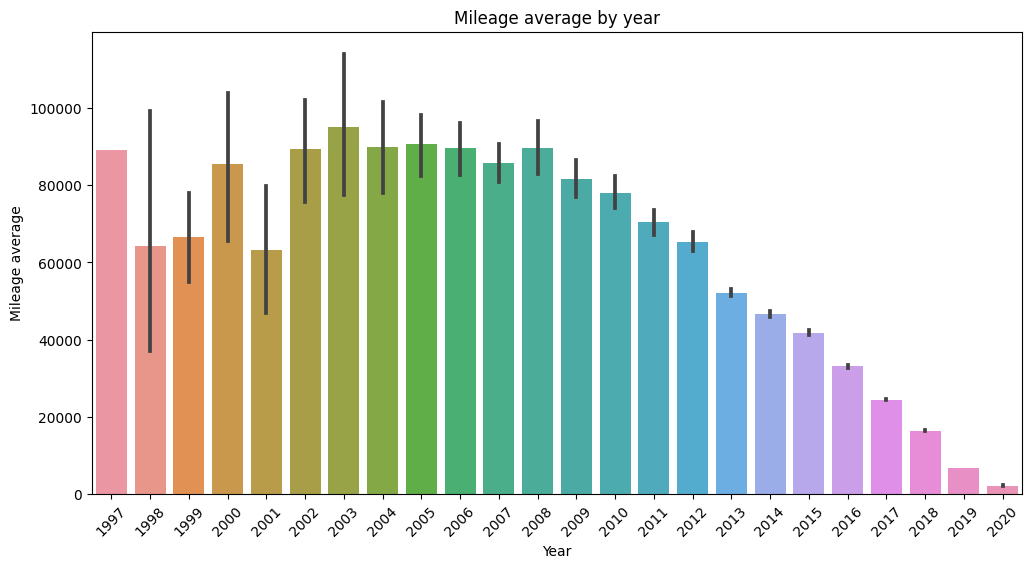

In [ ]:
# Year에 따른 Mileage 평균으로 대치 시도

plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='mileage', data=df_train)
plt.xticks(rotation=45)
plt.title('Mileage average by year')
plt.xlabel('Year')
plt.ylabel('Mileage average')
plt.show()

In [ ]:
# 결측치를 년도별 마일리지 평균값으로 대체
df_train['mileage'] = df_train.groupby('year')['mileage'].transform(lambda x: x.fillna(x.mean()))

df_train.isnull().sum()

brand              0
model              0
year               0
transmission       0
mileage            0
fuelType           0
tax             5111
mpg             5592
engineSize         0
price              0
dtype: int64

In [ ]:
# # 평균값으로 대치
# df_train['mileage'].fillna(df_train['mileage'].mean(), inplace=True)

# df_train.isnull().sum()

In [ ]:
# mileage 결측치를
# 1. log함수로 회귀해서 대치  2. 년도별 평균값 대치 3. 전체평균 대치

# 추후 모델링 과정에서 비교해본 결과 년도별 평균값으로 대치하는 것이 더 좋은 성능을 내서 년도별 평균값 대치로 결정

### Tax

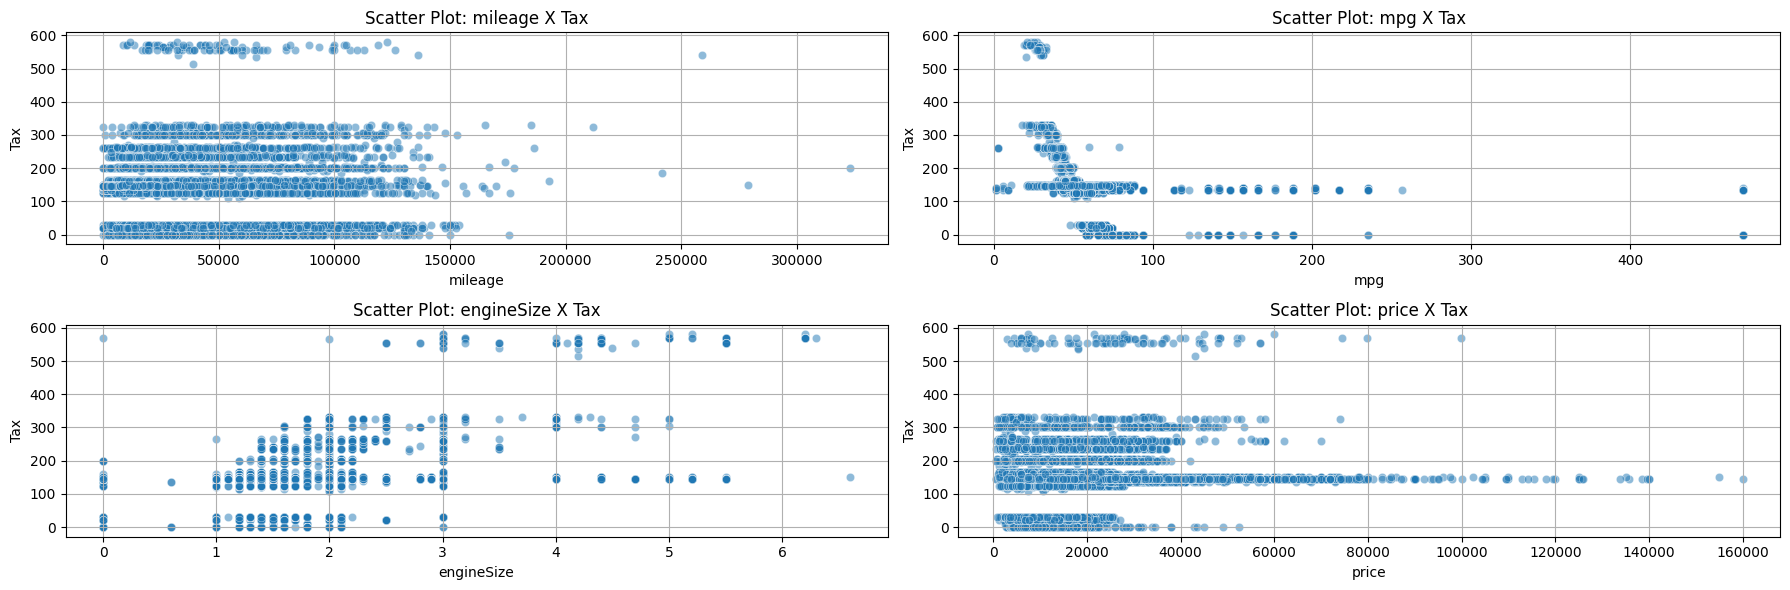

In [ ]:
# mpg, EngineSize Tax간의 산점도 그래프

# 변수 목록
features = ['mileage', 'mpg', 'engineSize', 'price']

# 산점도 그래프 시각화
plt.figure(figsize=(18, 6))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df_train, x=feature, y='tax', alpha=0.5)
    plt.title(f'Scatter Plot: {feature} X Tax')
    plt.xlabel(feature)
    plt.ylabel('Tax')
    plt.grid(True)

plt.tight_layout()
plt.show()

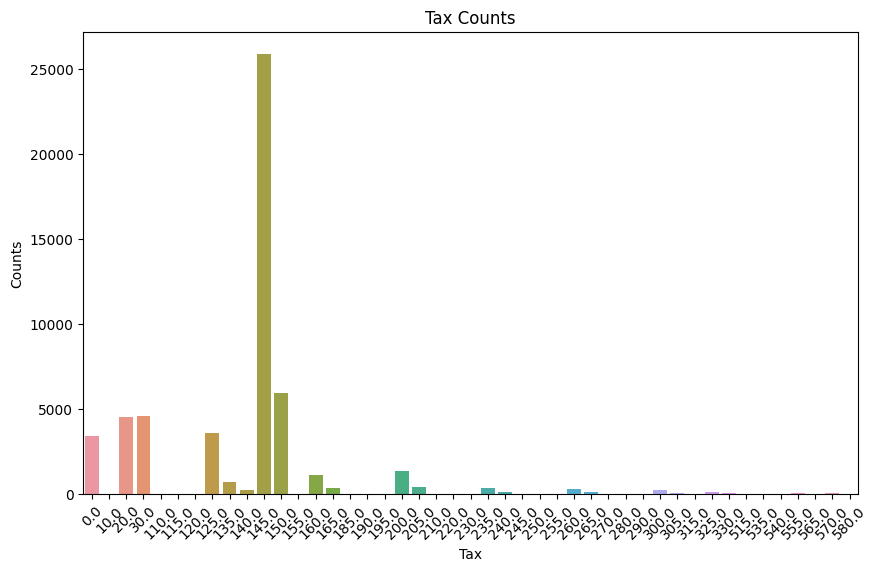

In [ ]:
# Tax의 데이터 분포를 확인하기 위한 countplot

plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='tax')
plt.xticks(rotation=45)
plt.title('Tax Counts')
plt.xlabel('Tax')
plt.ylabel('Counts')
plt.show()

In [ ]:
# 보유한 데이터 만으로 Tax를 특정하기 쉽지 않음
# Tax는 해당국가의 정책 등 고려할 사항이 많음
# Tax의 분포가 평균값에 극단적으로 밀집되어 있는것으로 보임
# 따라서 결측치를 평균값으로 대치
df_train['tax'].fillna(df_train['tax'].mean(), inplace=True)

df_train.isnull().sum()

brand              0
model              0
year               0
transmission       0
mileage            0
fuelType           0
tax                0
mpg             5592
engineSize         0
price              0
dtype: int64

### MPG

In [ ]:
# mpg(연비)는 차종과 연식에 따라 정해지는 값이다.
# 따라서 차량 모델별로 mpg값의 최빈값을 구해서 결측치에 해당하는 모델별로 최빈값으로 대치

# 차량 모델별 mpg 최빈값 계산
mode_mpg_by_model = df_train.dropna(subset=['mpg']).groupby('model')['mpg'].apply(lambda x: x.mode().iloc[0])

# 결측치를 모델별 최빈값으로 대치
def fill_missing_mpg(row):
    if pd.isna(row['mpg']):
        if row['model'] in mode_mpg_by_model.index:
            return mode_mpg_by_model[row['model']]
        else:
            return row['mpg']  # 해당 모델의 최빈값이 없는 경우 결측치 그대로 유지
    else:
        return row['mpg']

df_train['mpg'] = df_train.apply(fill_missing_mpg, axis=1)

df_train.isnull().sum()

brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             1
engineSize      0
price           0
dtype: int64

In [ ]:
# mpg 최빈값이 존재하지 않는 model의 mpg열에 결측치 1개 존재
# 데이터 내부에 유일하게 존재하는 model 이면서 mpg 가 결측치
df_train[df_train['mpg'].isnull()]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
48190,ford,Streetka,2005,Manual,63000.0,Petrol,270.0,NaN,1.6,1999


In [ ]:
# 해당열의 차량 model과 등록 연도를 고려하여 구글링후 결측치 대치
# Ford사의 Streetk의 평균 mpg 값은 33

df_train.loc[48190, 'mpg'] = 33

df_train.isnull().sum()

brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

# EDA

## Brand

<Axes: xlabel='brand', ylabel='price'>

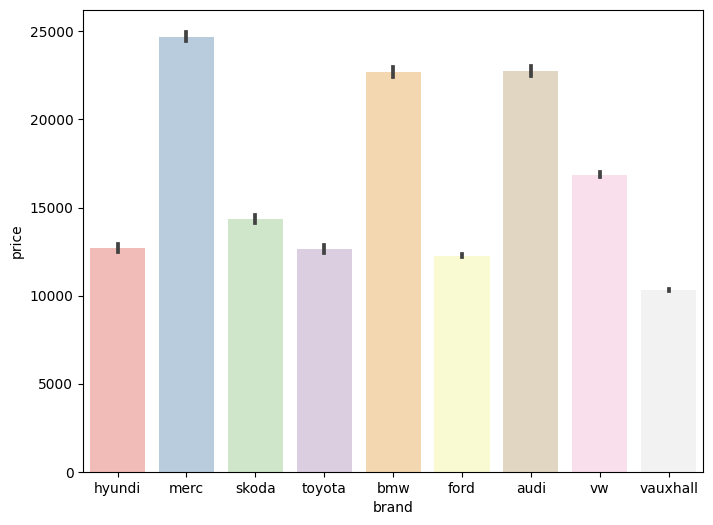

In [ ]:
# Brand와 Price에 대한 관계성을 파악하기 위해 barplot 시각화

plt.figure(figsize=(8,6))
sns.barplot(x='brand', y='price', data=df_train, palette='Pastel1')

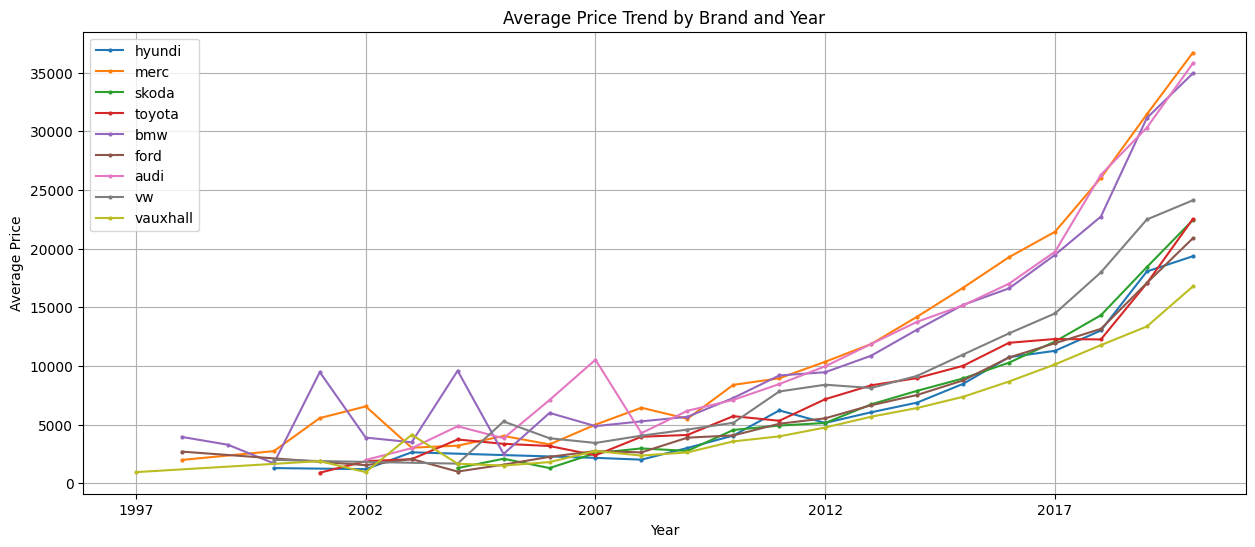

In [ ]:
# brand별 년도에 따른 가격 분포를 보기위한 꺽은선 그래프

df_train = df_train[df_train['year'] >= 1997]
brand_prices = df_train.groupby(['brand', 'year'])['price'].mean().reset_index()
brands = df_train['brand'].unique()

plt.figure(figsize=(15, 6))

for brand in brands:
    brand_data = brand_prices[brand_prices['brand'] == brand]
    plt.plot(brand_data['year'], brand_data['price'], marker='o', linestyle='-', label=brand ,markersize=2)

plt.title('Average Price Trend by Brand and Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)

plt.xticks(range(1997, max(df_train['year']) + 1, 5))

plt.show()


In [ ]:
# brand 가격대 별로 재범주화
# (merc, audi, bmw)-> High
# (vw, skoda) -> Middle
# (hyundi, ford, toyota, vauxhall) -> low

df_new = df_train.copy()
df_new['brand']= df_train['brand'].replace({'merc': 'High', 'audi': 'High', 'bmw': 'High',
                                     'vw': 'Middle','skoda': 'Middle',
                                     'hyundi': 'low','ford': 'low','toyota': 'low','vauxhall': 'low'})

# Test 데이터에도 똑같이 적용
df_test_new = df_test.copy()
df_test_new['brand']= df_test['brand'].replace({'merc': 'High', 'audi': 'High', 'bmw': 'High',
                                     'vw': 'Middle','skoda': 'Middle',
                                     'hyundi': 'low','ford': 'low','toyota': 'low','vauxhall': 'low'})

# 추후 인코딩 할때 필요한 brand_model 데이터에도 똑같이 적용

df_brand = pd.read_csv('/content/gdrive/MyDrive/IBA/IBA_reg_comp/brand_model.csv')

df_brand_new = df_brand.copy()
df_brand_new['brand'] = df_brand['brand'].replace({'merc': 'High', 'audi': 'High', 'bmw': 'High',
                                     'vw': 'Middle','skoda': 'Middle',
                                     'hyundi': 'low','ford': 'low','toyota': 'low','vauxhall': 'low'})

## Price와 연속형 변수들간의 관계

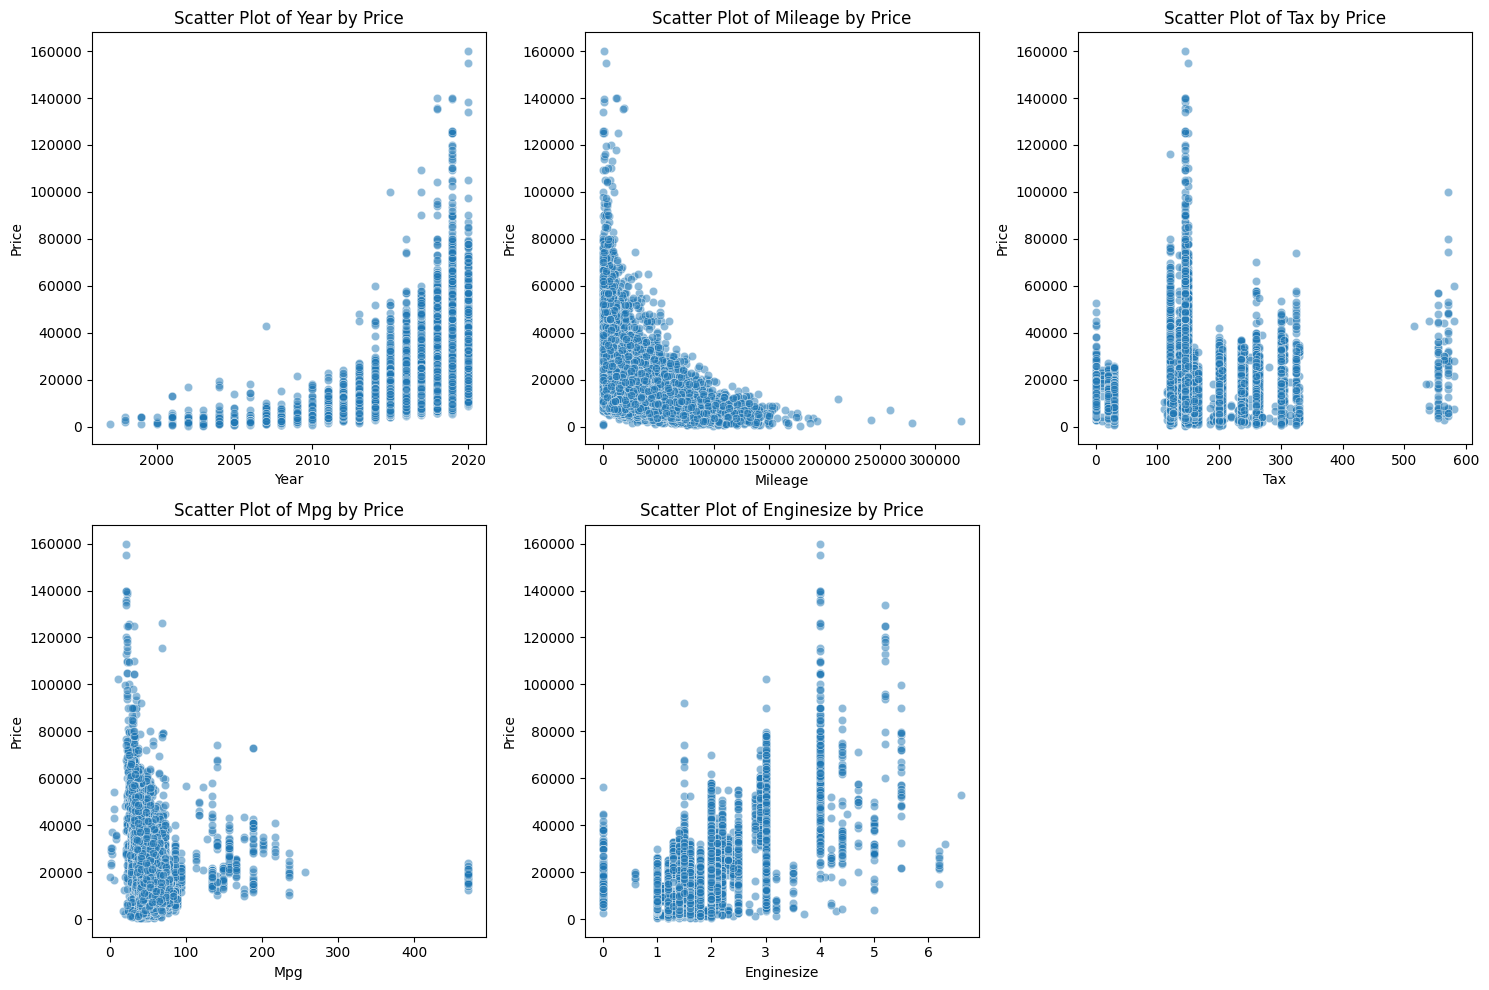

In [ ]:
# mileage, tax, mpg 와 price 의 관계를 산점도그래프로 시각화
missing_features = ['year','mileage', 'tax', 'mpg', 'engineSize']

plt.figure(figsize=(15, 10))

for i, var in enumerate(missing_features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(data=df_train, x=var, y='price', alpha=0.5)
    plt.title(f'Scatter Plot of {var.capitalize()} by Price')
    plt.xlabel(var.capitalize())
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

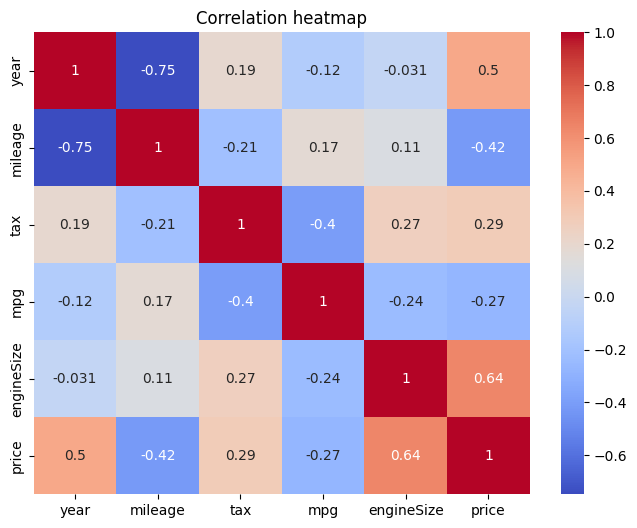

In [ ]:
# Price 와 연속형 변수들 간의 상관관계 Heatmap

numeric_cols = df_new.select_dtypes(include=['float64', 'int64','int32'])

model_cols_to_exclude = [col for col in numeric_cols.columns if col.startswith('model_')]
numeric_cols = numeric_cols.drop(columns=model_cols_to_exclude)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap ='coolwarm')
plt.title('Correlation heatmap')
plt.show()

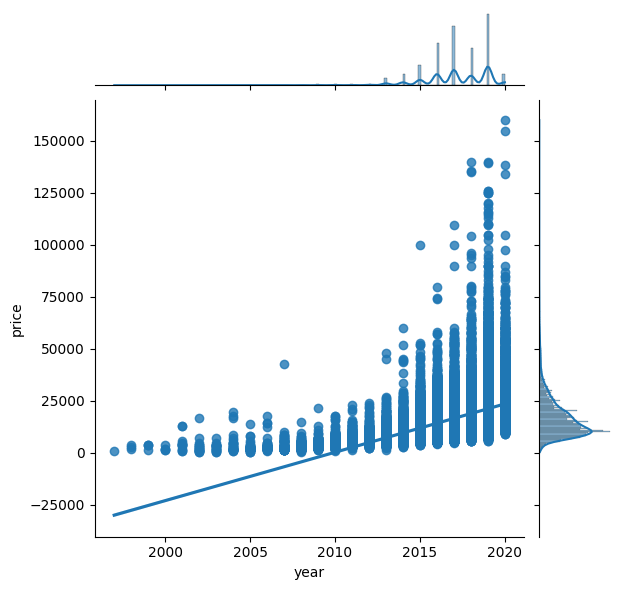

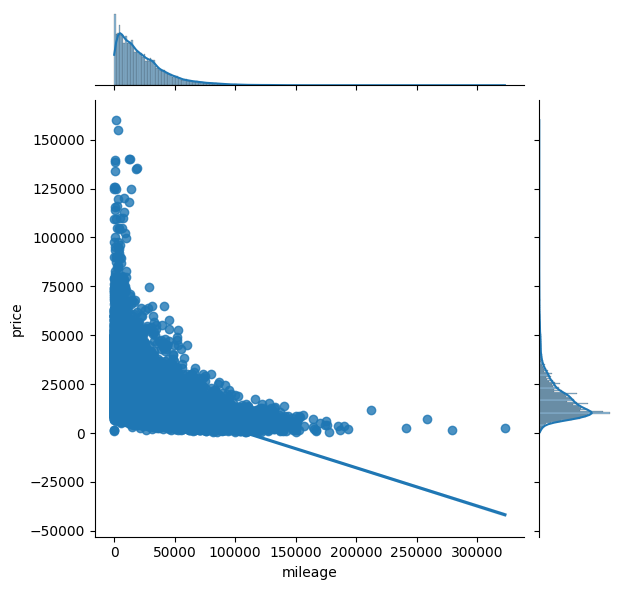

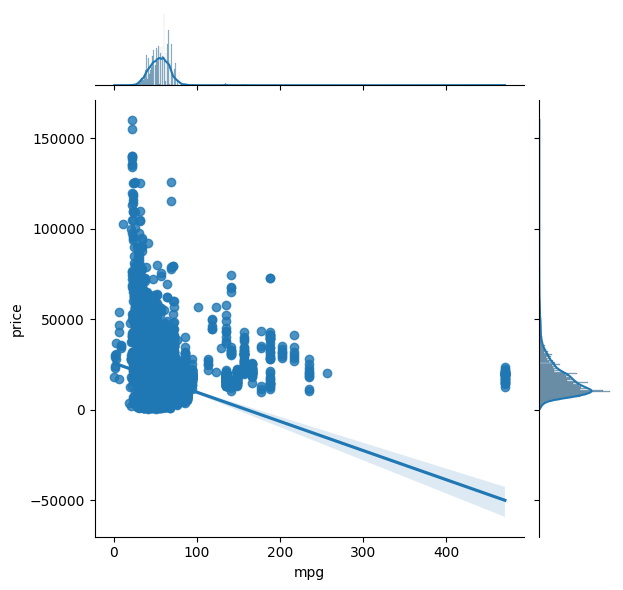

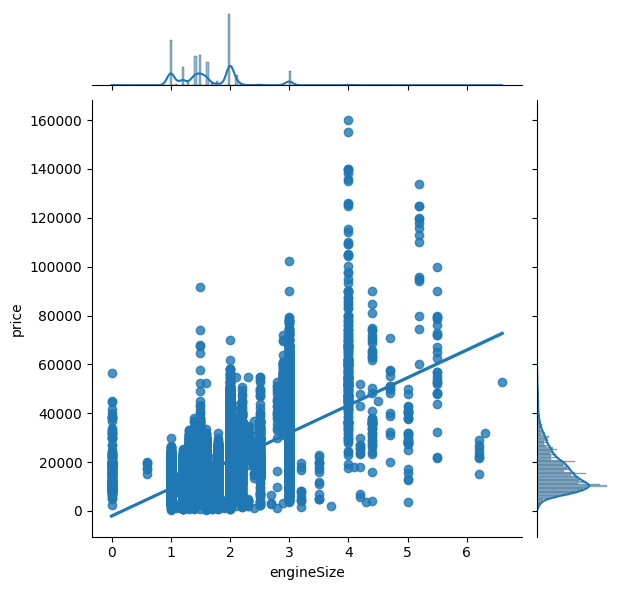

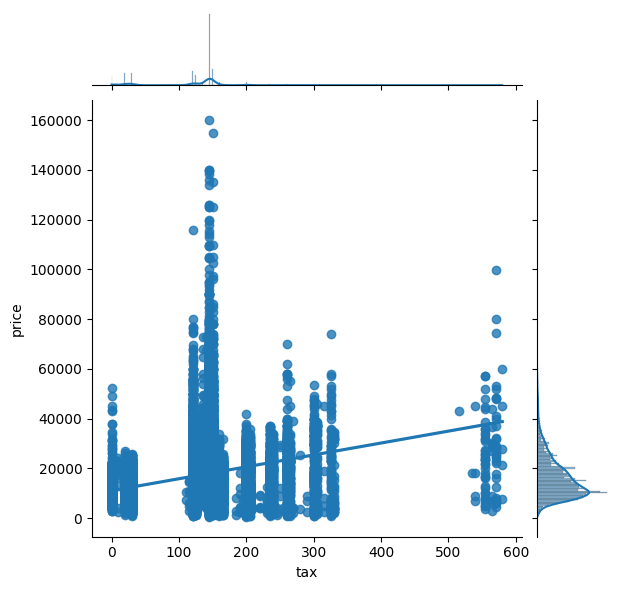

In [ ]:
# Price 와 연속형 변수들 간의 산점도 그래프와 회귀 직선

features = ['year', 'mileage', 'mpg', 'engineSize', 'tax']
for i in features:
    sns.jointplot(x=i,y='price',data=df_new,kind='reg')

## Mission2: 중고로 차를 판매할 것이라는 가정 하에 우리 팀이라면 어떤 브랜드의 차를 구매할지

In [ ]:
# 우리 팀은 중고로 차를 판매할 것이라는 가정 하에 시간이 지날수록 감가가 가장 작은 브랜드를 구매하는 것이 유리하다고 판단했음

<Figure size 1200x600 with 0 Axes>

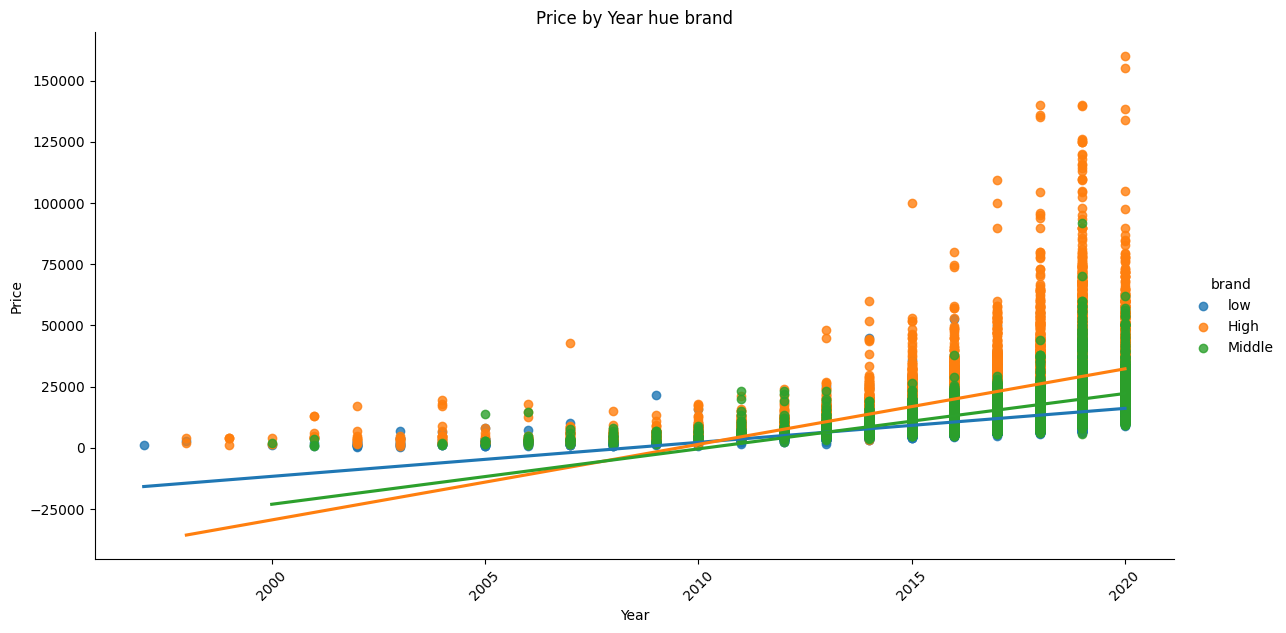

In [ ]:
# 가격대별 재범주화한 Brand의 Year에 따른 Price 추세를 lmplot으로 시각화

plt.figure(figsize=(12, 6))
sns.lmplot(x='year', y='price', data=df_new, hue='brand', height=6, aspect=2, ci=None)
plt.xticks(rotation=45)
plt.title('Price by Year hue brand')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

<Figure size 1200x600 with 0 Axes>

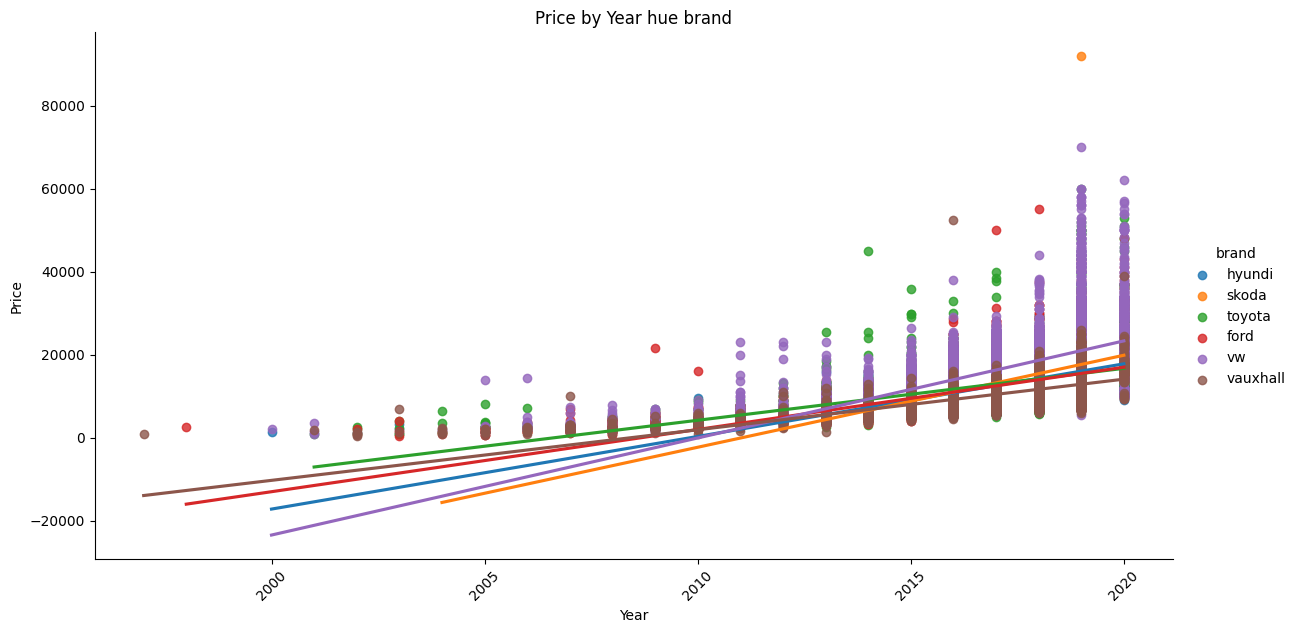

In [ ]:
# 가격대가 High인 브랜드는 년도가 지날수록 가격이 확연히 낮아짐을 확인할 수 있음
# 따라서 가격대가 낮은 브랜드만 모아서 다시 lmplot으로 시각화 진행

brands_to_remove = ['audi', 'merc', 'bmw']
df_dropped_high = df_train[~df_train['brand'].isin(brands_to_remove)]
plt.figure(figsize=(12, 6))
sns.lmplot(x='year', y='price', data=df_dropped_high, hue='brand', height=6, aspect=2, ci=None)
plt.xticks(rotation=45)
plt.title('Price by Year hue brand')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [ ]:
# brand별로 회귀선의 기울기를 저장할 리스트 생성
brand_slopes = []

# brand 고유값 가져오기
brands = df_dropped_high['brand'].unique()

# brand별로 회귀선 추정
for brand in brands:
    brand_data = df_train[df_train['brand'] == brand]

    # 회귀 모델 추정
    X = brand_data['year']
    y = brand_data['price']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # 회귀 모델의 기울기 추출
    slope = model.params['year']

    # 결과를 리스트에 추가
    brand_slopes.append((brand, slope))

# 결과 출력
for brand, slope in brand_slopes:
    print(f'Brand: {brand}, Slope: {slope}')

Brand: hyundi, Slope: 1748.8641052392131
Brand: skoda, Slope: 2216.0795612851743
Brand: toyota, Slope: 1250.4438437962092
Brand: ford, Slope: 1498.8134120350596
Brand: vw, Slope: 2337.651496934843
Brand: vauxhall, Slope: 1218.1810302769723


<Figure size 1200x600 with 0 Axes>

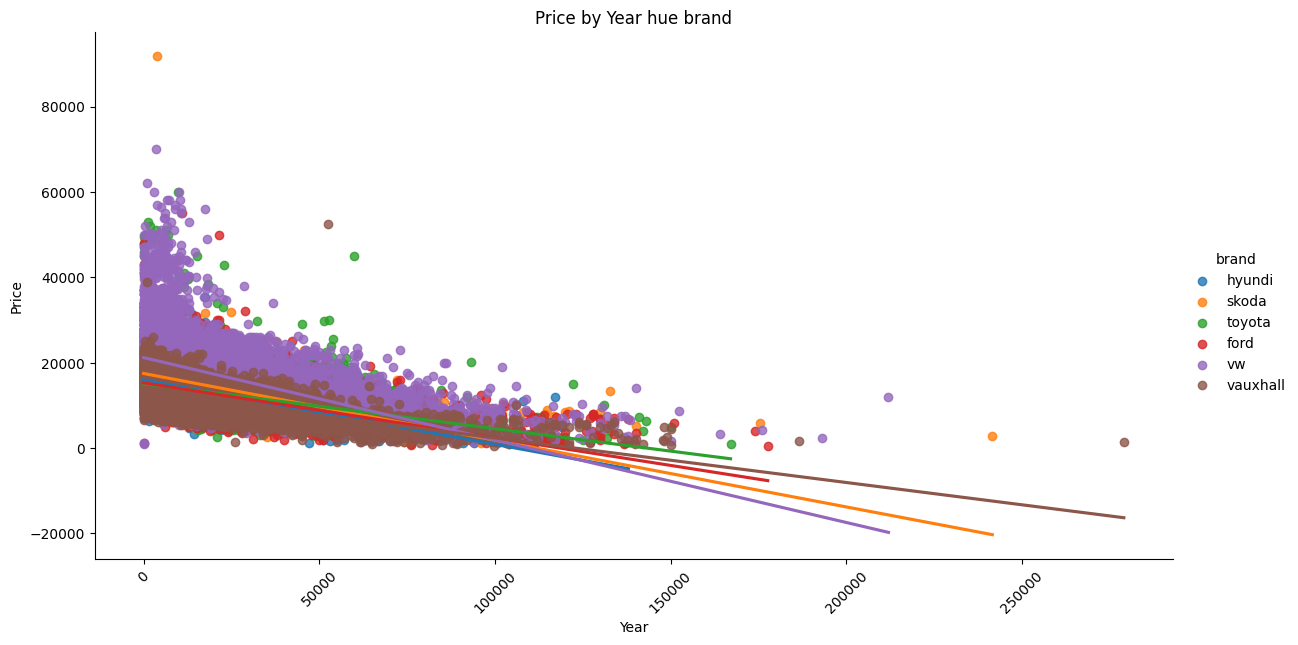

In [ ]:
# 가격대가 High인 브랜드는 년도가 지날수록 가격이 확연히 낮아짐을 확인할 수 있음
# 따라서 가격대가 낮은 브랜드만 모아서 다시 lmplot으로 시각화 진행

brands_to_remove = ['audi', 'merc', 'bmw']
df_dropped_high = df_train[~df_train['brand'].isin(brands_to_remove)]
plt.figure(figsize=(12, 6))
sns.lmplot(x='mileage', y='price', data=df_dropped_high, hue='brand', height=6, aspect=2, ci=None)
plt.xticks(rotation=45)
plt.title('Price by Year hue brand')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [ ]:
# brand별로 회귀선의 기울기를 저장할 리스트 생성
brand_slopes = []

# brand 고유값 가져오기
brands = df_dropped_high['brand'].unique()

# brand별로 회귀선 추정
for brand in brands:
    brand_data = df_train[df_train['brand'] == brand]

    # 회귀 모델 추정
    X = brand_data['mileage']
    y = brand_data['price']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # 회귀 모델의 기울기 추출
    slope = model.params['mileage']

    # 결과를 리스트에 추가
    brand_slopes.append((brand, slope))

# 결과 출력
for brand, slope in brand_slopes:
    print(f'Brand: {brand}, Slope: {slope}')

Brand: hyundi, Slope: -0.1504324076613181
Brand: skoda, Slope: -0.15629915196416996
Brand: toyota, Slope: -0.10507386973235425
Brand: ford, Slope: -0.12904481422037248
Brand: vw, Slope: -0.1930986399566161
Brand: vauxhall, Slope: -0.10442493747411441


In [ ]:
# toyota와 vauxhall의 시간과 주행거리에 따른 가격 하락 추이가 가장 완만한 것으로 판단

      Brand  Correlation
0      audi     0.593926
1       bmw     0.630437
2      ford     0.650007
3    hyundi     0.591427
4      merc     0.536778
5     skoda     0.601008
6    toyota     0.426705
7  vauxhall     0.710372
8        vw     0.619038


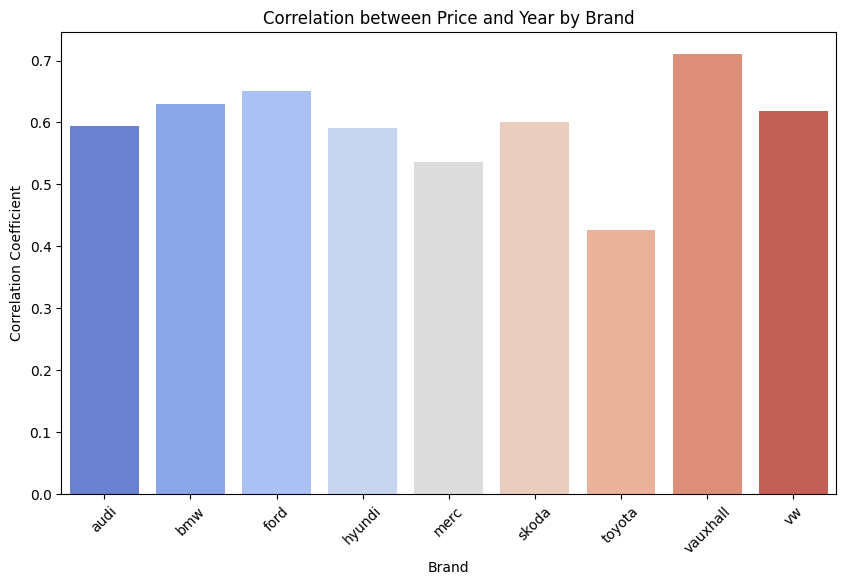

In [ ]:
# 브랜드별 년도와 가격간의 상관계수 계산
correlations = df_train.groupby('brand')[['price', 'year']].corr().iloc[1::2]['price'].reset_index()
correlations.columns = ['Brand','Additional_Column','Correlation']
correlations.drop('Additional_Column', axis=1, inplace=True)
print(correlations)

# 브랜드별 상관계수 비교를 위한 barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Brand', y='Correlation', data=correlations, palette='coolwarm')
plt.xlabel('Brand')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between Price and Year by Brand')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# toyota가 브랜드별 년도와 가격간의 상관계수가 가장 약함

# 따라서 toyota는 시간과 주행거리에 따른 가격 하락 폭이 완만하고, 년도와 가격간의 상관계수가 가장 약하므로
# 차량을 구매한 후 중고로 차를 판매할때 유리하다고 판단됨

# 모델링 준비

## Feature select

<Figure size 1000x600 with 0 Axes>

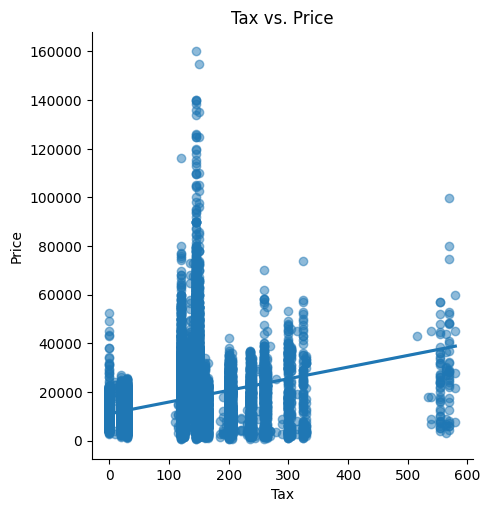

In [ ]:
plt.figure(figsize=(10, 6))

# lmplot을 사용하여 회귀선을 포함한 그래프 생성
sns.lmplot(x='tax', y='price', data=df_new, scatter_kws={'alpha': 0.5})

# 그래프 제목 설정
plt.title('Tax vs. Price')

# x, y 축 레이블 설정
plt.xlabel('Tax')
plt.ylabel('Price')

# 그래프 표시
plt.show()

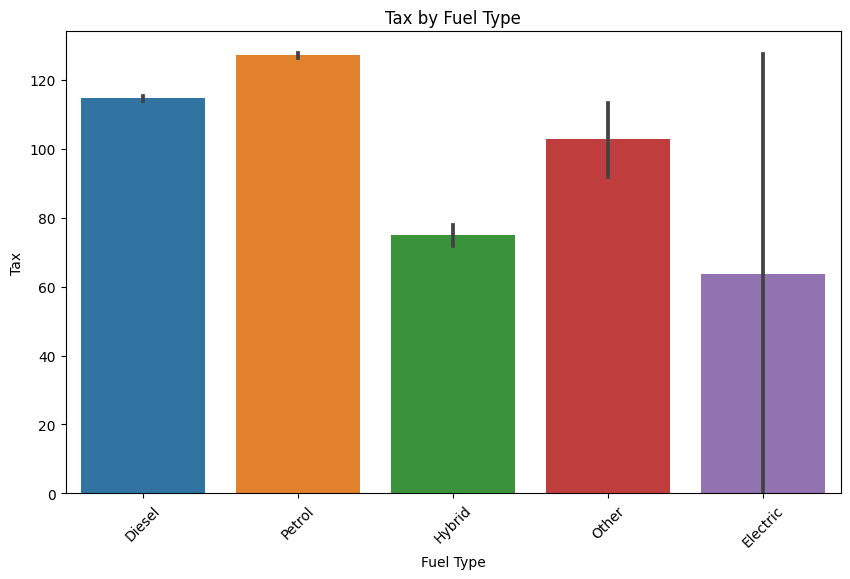

In [ ]:
plt.figure(figsize=(10, 6))

# 'tax'와 'fuelType' 데이터를 사용하여 바 그래프 생성
sns.barplot(x='fuelType', y='tax', data=df_new)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Tax by Fuel Type')

# x, y 축 레이블 설정
plt.xlabel('Fuel Type')
plt.ylabel('Tax')

# 그래프 표시
plt.show()

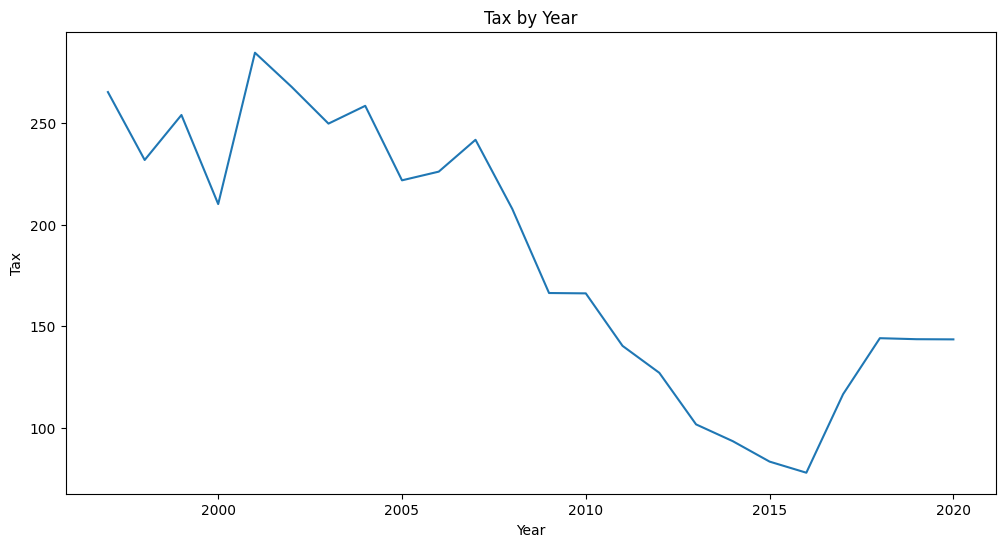

In [ ]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 선 그래프 생성
sns.lineplot(x='year', y='tax', data=df_new, ci=None)

# 그래프 제목 설정
plt.title('Tax by Year')

# x, y 축 레이블 설정
plt.xlabel('Year')
plt.ylabel('Tax')

# 그래프 표시
plt.show()

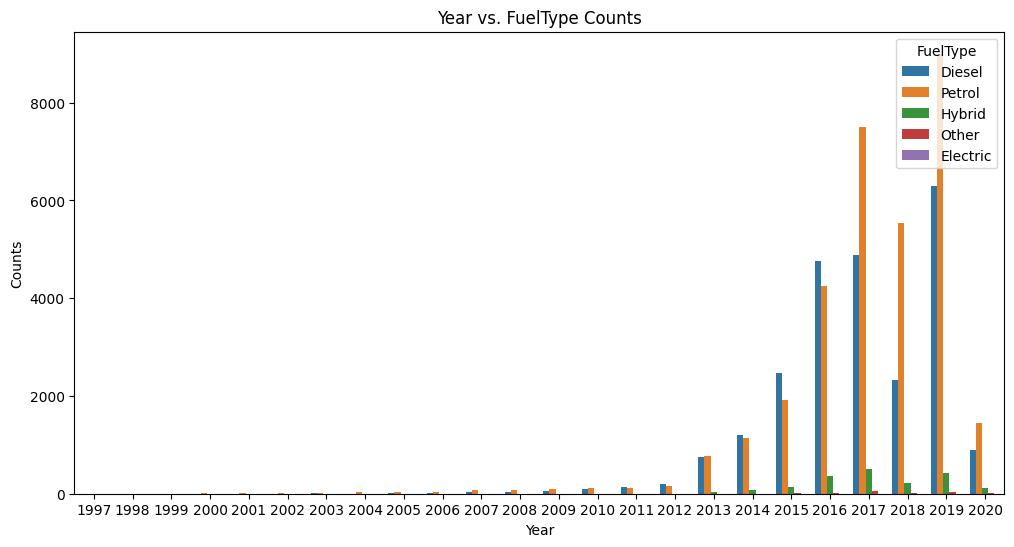

In [ ]:
# countplot 그래프 그리기
plt.figure(figsize=(12, 6))
sns.countplot(x='year', hue='fuelType', data=df_train)
plt.title('Year vs. FuelType Counts')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(title='FuelType', loc='upper right')
plt.show()

In [ ]:
# Price와 Tax사이의 선형회귀분석
Y = df_new['price']
X = df_new['tax']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5529.
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:21:43   Log-Likelihood:            -6.1977e+05
No. Observations:               58625   AIC:                         1.240e+06
Df Residuals:                   58623   BIC:                         1.240e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.104e+04     86.610    127.485      0.0

In [ ]:
# 회귀분석 결과
# R-squared 값이 낮으므로 tax 변수가 price를 설명하는 것은 어려울 것으로 판단됨.

In [ ]:
# 2017년 4월 1일 부로 내연기관에 대한 세금 가중부과 규제가 시작되었다.
# 세금이 가중부과 된 차량인 내연기관 차량의 매물이 증가하므로 해당년도 부터 Tax가 상승함.

# 결론은 모델 학습에 Tax feature는 제거함

## 인코딩

### Brand, Model label encoding

In [ ]:
# 범주형 변수에서 train의 class와 test의 class가 같은지, 다른지 확인
object_features = ['model', 'brand', 'transmission', 'fuelType']

for feature in object_features:
    # train set에 있는 클래스 확인
    train_classes = set(df_new[feature])

    # test set에만 있는 클래스 확인
    test_classes = set(df_test_new[feature]) - train_classes
    if test_classes:
        print(f'{feature} : {test_classes}')
    else:
        print(f'{feature} : 없음')


model : {' A2', ' Veloster', '220', '200', ' Escort', '180', ' Ranger', ' Kadjar', '230'}
brand : 없음
transmission : 없음
fuelType : 없음


In [ ]:
from sklearn.preprocessing import LabelEncoder
object_features = ['brand', 'model']

for feature in object_features:
    le = LabelEncoder()
    le = le.fit(df_brand_new[feature].unique()) # 각 범주형 변수의 주어진 class에 대해 fit

    df_new[feature] = le.transform(df_new[feature]) # df_train에 적용
    df_test_new[feature] = le.transform(df_test_new[feature]) # df_test에 적용

### Transmission, FuelType label encoding

In [ ]:
object_features = ['transmission', 'fuelType']

for feature in object_features:
    # train set에 있는 클래스 확인
    train_classes = set(df_new[feature])

    # test set에만 있는 클래스 확인
    test_classes = set(df_test_new[feature]) - train_classes

    if len(test_classes) != 0: # train에서의 class와 test에서의 class가 다른 경우
        df_test_new.loc[df_test_new[feature].isin(test_classes), feature] = 'Unknown'
        le = LabelEncoder()
        le = le.fit(df_new[feature])
        df_new[feature] = le.transform(df_new[feature])
        le.classes_ = np.append(le.classes_, 'Unknown')
        df_test_new[feature] = le.transform(df_test_new[feature])
        print(f'{feature} 컬럼은 test set에만 있는 클래스 {test_classes}를 포함하고 있습니다.')

    else: # train에서의 class와 test에서의 class가 같은 경우
        le = LabelEncoder()
        le = le.fit(df_new[feature])
        df_new[feature] = le.transform(df_new[feature])
        df_test_new[feature] = le.transform(df_test_new[feature])

# 모델링 및 평가

## 모델 선택을 위해 6가지 회귀모델로 k-fold 교차검증 수행

In [ ]:
# 6가지 회귀 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 데이터 준비
X = df_new.drop(columns=['price', 'tax'], axis=1)
y = df_new['price']

# 회귀 모델
regression_models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'GBM': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(silent=True)
}

# 모델링 및 k-fold 교차검증, 평가지표(RMSE)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in regression_models.items():
    rmse_scores = []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = sqrt(mse)
        rmse_scores.append(rmse)

    avg_rmse = np.mean(rmse_scores)
    print(f"{model_name} K-Fold Cross-Validated RMSE: {avg_rmse:.2f}")

Decision Tree K-Fold Cross-Validated RMSE: 2793.97
Random Forest K-Fold Cross-Validated RMSE: 2151.88
GBM K-Fold Cross-Validated RMSE: 3015.19
XGBoost K-Fold Cross-Validated RMSE: 2050.03
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 46900, number of used features: 8
[LightGBM] [Info] Start training from score 16747.322985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 46900, number of used features: 8
[LightGBM] [Info] Start training from score 16788.086205
[LightGBM] [Warning] Auto-choosing col-wise multi-thre

In [ ]:
# XGBoost 와 CatBoost 두모델이 근소한 차이를 보이며 가장 성능이 좋게 나타남

## 특성 중요도

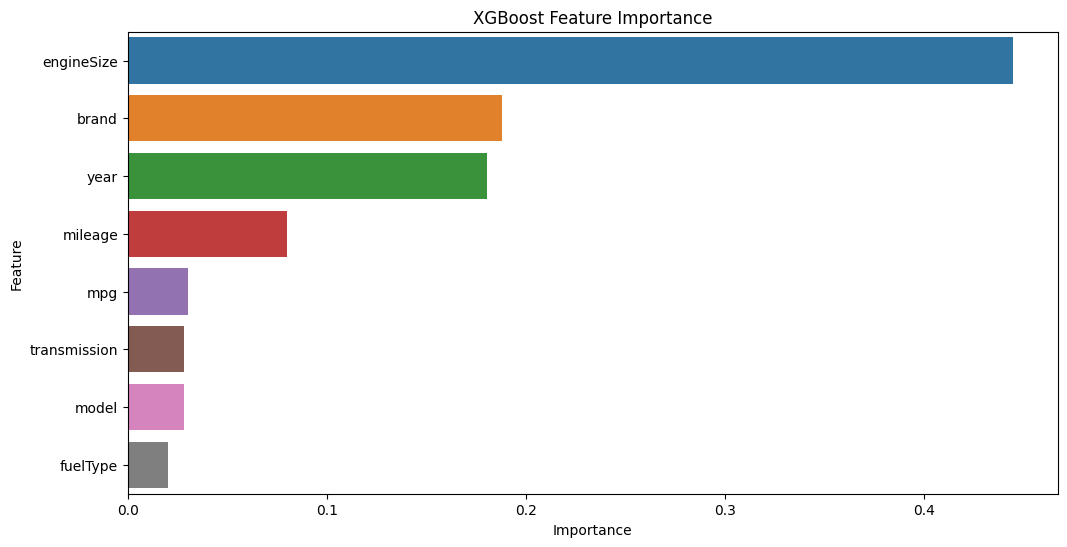

In [ ]:
# XGBoost 모델의 특성 중요도
feature_importances_xgboost = regression_models['XGBoost'].feature_importances_

# 특성 중요도를 데이터프레임으로 만들기
df_importance_xgboost = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_xgboost})
df_importance_xgboost = df_importance_xgboost.sort_values(by='Importance', ascending=False)

# barplot으로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance_xgboost)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

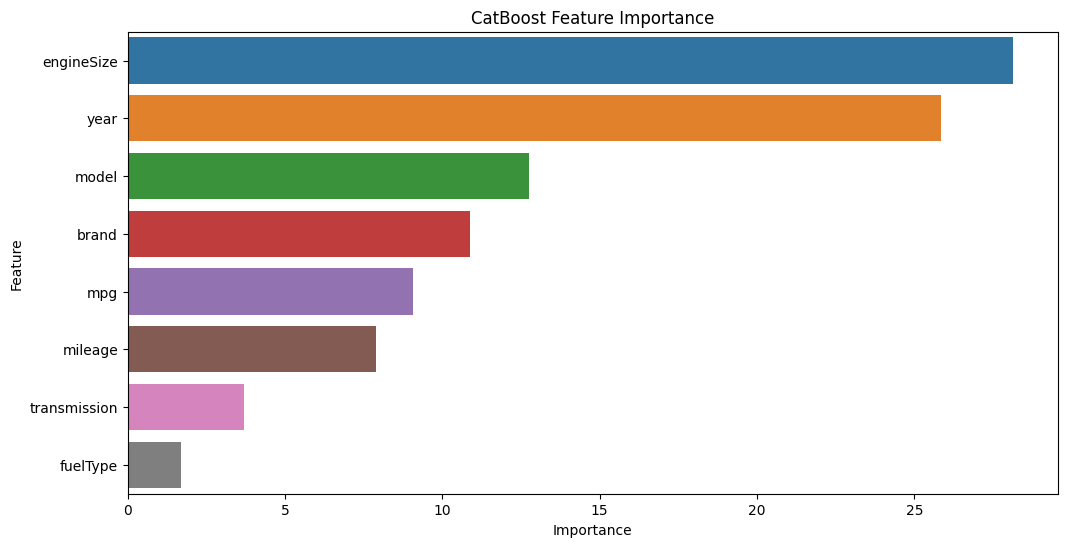

In [ ]:
# CatBoost 모델의 특성 중요도
feature_importances_catboost = regression_models['CatBoost'].feature_importances_

# 특성 중요도를 데이터프레임으로 만들기
df_importance_catboost = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_catboost})
df_importance_catboost = df_importance_catboost.sort_values(by='Importance', ascending=False)

# barplot으로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance_catboost)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## XGBoost 하이퍼파라미터 튜닝

In [ ]:
# XGBoost 모델 생성
xgb_reg = XGBRegressor()

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Grid Search 객체 생성
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 조합 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델 선택
best_xgb = grid_search.best_estimator_

# 최적 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = best_xgb.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0}
RMSE: 2029.3867283523407
MAE: 1366.8689856712813
R-squared: 0.9577834150228782


In [ ]:
# 파라미터 그리드 수정후 다시 그리드서치 수행

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.2],
    'subsample': [1.0],
    'colsample_bytree': [0.8]
}

# Grid Search 객체 생성
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 조합 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델 선택
best_xgb = grid_search.best_estimator_

# 최적 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = best_xgb.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
RMSE: 1319.4575755263293
MAE: 917.6636349905051
R-squared: 0.9821538586231384


### XGBoost 조기 종료 설정

In [ ]:
# 최적의 하이퍼파라미터 튜닝
# 과적합 방지를 위한 조기 종료(early_stopping) 설정

# Train/Test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 초기화 및 하이퍼파라미터 설정
best_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0  # 출력 메시지 끄기
)

# 조기 종료 설정
eval_set = [(X_test, y_test)]  # 검증 데이터셋 설정
best_xgb.fit(
    X_train, y_train,
    eval_set=eval_set,
    early_stopping_rounds=50,  # 성능 향상이 없는 경우 50번까지 기다림
    verbose=False  # 조기 종료 메시지 출력 끄기
)

# 테스트 데이터에 대한 예측
y_pred = best_xgb.predict(X_test)

# 평가지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

RMSE: 2033.5707229527661
MAE: 1231.616632993801
R-squared: 0.9600322103735431


## CatBoost 하이퍼파라미터 튜닝

In [ ]:
# CatBoost 모델 생성
catboost_reg = CatBoostRegressor(random_state=100, early_stopping_rounds=50, silent=True)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Grid Search 객체 생성
grid_search = GridSearchCV(estimator=catboost_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 조합 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델 선택
best_catboost = grid_search.best_estimator_

# 최적 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = best_catboost.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

Best Parameters: {'learning_rate': 0.3, 'max_depth': 5}
RMSE: 1603.4370870692612
MAE: 1092.9425871372393
R-squared: 0.9736453461597735


In [ ]:
# 파라미터 그리드 수정후 다시 그리드서치 수행

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.3],
    'max_depth': [5, 6, 7]
}

# Grid Search 객체 생성
grid_search = GridSearchCV(estimator=catboost_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Grid Search 수행
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 조합 출력
print("Best Parameters:", grid_search.best_params_)

# 최적 모델 선택
best_catboost = grid_search.best_estimator_

# 최적 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = best_catboost.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}
RMSE: 1710.4498143349745
MAE: 1157.5801415975293
R-squared: 0.970010160620271


### CatBoost 조기 종료 설정

In [ ]:
# 최적의 하이퍼파라미터 튜닝
# 과적합 방지를 위한 조기 종료(early_stopping) 설정

# Train/Test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CatBoost 모델 초기화 및 하이퍼파라미터 설정
best_catboost = CatBoostRegressor(
    learning_rate=0.3,
    max_depth=5,
    random_state=42,
    silent=True  # 출력 메시지 끄기
)

# 조기 종료 설정
best_catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # 검증 데이터셋 설정
    early_stopping_rounds=50,  # 성능 향상이 없는 경우 50번까지 기다림
    verbose=False  # 조기 종료 메시지 출력 끄기
)

# 테스트 데이터에 대한 예측
y_pred = best_catboost.predict(X_test)

# 평가지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

RMSE: 2001.803613690269
MAE: 1258.3410508962293
R-squared: 0.9612711584156806


# 결과 제출

In [ ]:
# 데이터 준비
X = df_new.drop(columns=['price', 'tax'], axis=1)
y = df_new['price']
y_test = df_test_new.drop('id', axis=1)

# 모델 학습

best_catboost.fit(X, y)
y_pred = best_catboost.predict(y_test)

In [ ]:
submission = pd.read_csv('/content/gdrive/MyDrive/IBA/IBA_reg_comp/sample_submission.csv')
submission['price'] = y_pred

submission.to_csv('./submit2.csv', index = False)